# GPT from scratch

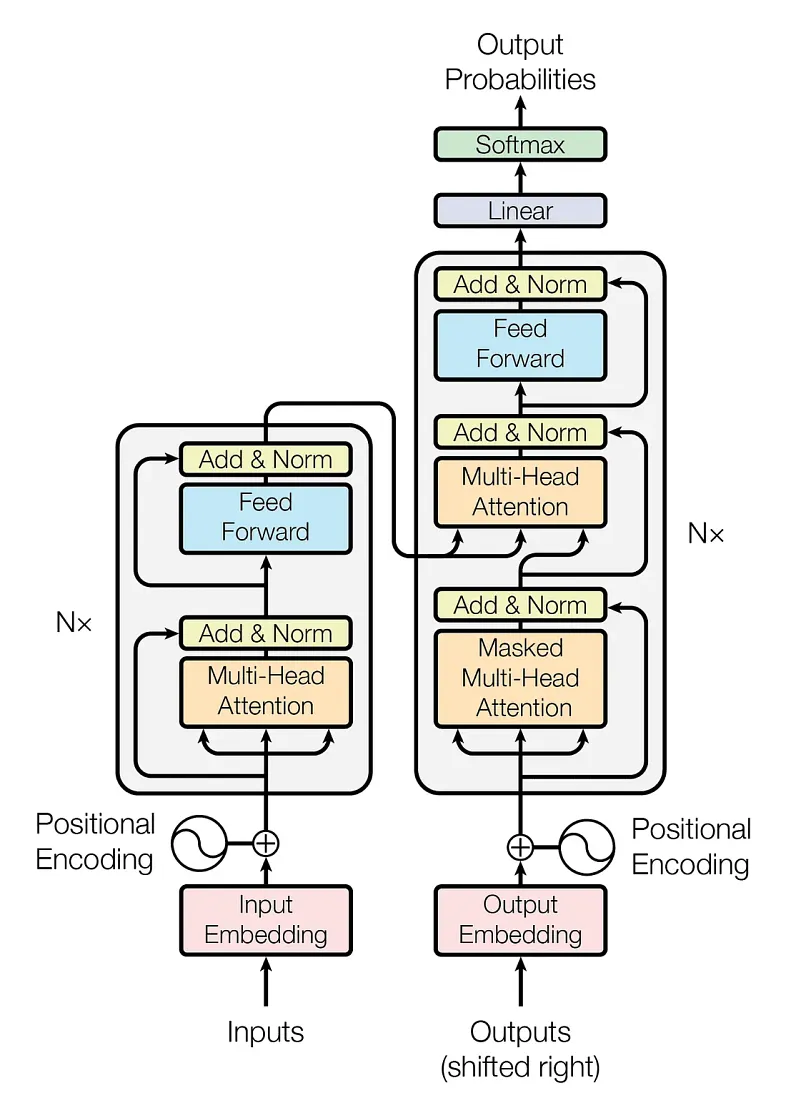

In [33]:
# Importing libraries

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

# Math
import math

# HuggingFace libraries 
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

# Pathlib 
from pathlib import Path

# typing
from typing import Any

# Library for progress bars in loops
from tqdm import tqdm

# Importing library of warnings
import warnings

import numpy as np

## Input Embeddings

The InputEmbedding class below is responsible for converting the input text into numerical vectors of d_model dimensions. 

To prevent that our input embeddings become extremely small, we normalize them by multiplying them by the √𝑑_𝑚𝑜𝑑𝑒𝑙

In [34]:
# Lets create the Inputs Embedding Layer


class InputEmbeddings(nn.Module):
    """
    This is the initial input layer for the text.
    It will create all the words into embeddings.

    For example if we have a sentence with 10 words
    then we will get a matrix of 10(words)*output_dimension(embeddings) vectors

    Inputs:
    * output_dimension: The embeddings size
    * vocab_size: Is the number of total unique words that we will support in our vocab
    """

    # create the init function
    def __init__(self, output_dimension: int, vocab_size: int):
        super().__init__()
        self.output_dimension = output_dimension
        self.vocab_size = vocab_size
        # Initialize the embedding matrix
        self.embedding_layer = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=output_dimension
        )

    # create the forward pass how will behave
    def forward(self, x):
        embedding_calculation = self.embedding_layer(x)
        normalization_factor = np.sqrt(self.output_dimension)
        return embedding_calculation + normalization_factor

## Positional Encoding

In the original paper, the authors add the positional encodings to the input embeddings at the bottom of both the encoder and decoder blocks so the model 
* can have some information about the relative or absolute position of the tokens in the sequence.

The positional encodings have the same dimension 𝑑_model the embeddings
* so that the two vectors can be summed and we can combine the semantic content from the word embeddings and positional information from the positional encodings.

In [35]:
# Creating the Positional Encoding
class PositionEncoder(nn.Module):
    
    def __init__(self, output_dimensions: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.output_dimensions = output_dimensions # Dimensionality of the model
        self.seq_len = seq_len # Maximum sequence length
        self.dropout = nn.Dropout(dropout) # Dropout layer to prevent overfitting
        
        # Creating a positional encoding matrix of shape (seq_len, output_dimensions) filled with zeros
        pe = torch.zeros(seq_len, output_dimensions) 
        
        # Creating a tensor representing positions (0 to seq_len - 1)
        position = torch.arange(0, seq_len, dtype = torch.float).unsqueeze(1) # Transforming 'position' into a 2D tensor['seq_len, 1']
        
        # Creating the division term for the positional encoding formula
        div_term = torch.exp(torch.arange(0, output_dimensions, 2).float() * (-math.log(10000.0) / output_dimensions))
        
        # Apply sine to even indices in pe
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices in pe
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Adding an extra dimension at the beginning of pe matrix for batch handling
        pe = pe.unsqueeze(0)
        
        # Registering 'pe' as buffer. Buffer is a tensor not considered as a model parameter
        self.register_buffer('pe', pe) 
        
    def forward(self,x):
        # Addind positional encoding to the input tensor X
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x) # Dropout for regularization

## Layer Normalization

This is the Add & Norm layer.
The LayerNormalization class below performs layer normalization on the input data. During its forward pass, we compute the mean and standard deviation of the input data. We then normalize the input data by subtracting the mean and dividing by the standard deviation plus a small number called epsilon to avoid any divisions by zero.

In [36]:
class LayerNorm(nn.Module):
    def __init__(self, eps: float = 10e-6):
        super().__init__()

        # A small value to never divide by 0
        self.eps = eps

        # define a trainable parameter a and initialize with ones, same with bias
        self.alpha = nn.Parameter(torch.ones(1))
        self.bias = nn.Parameter(torch.ones(1))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        standarized_output = (x-mean)/(std + self.eps)
        return self.alpha * standarized_output + self.bias


## Feed-Forward Network

Lets create the feed forward layer which is easy before diving in the multi head attention layers

In the fully connected feed-forward network, we apply two linear transformations with a ReLU activation in between.

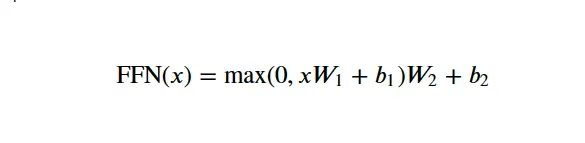

In [37]:
class FeedForward(nn.Module):

    def __init__(self, input_dim: int, between_dimension: int, dropout: float):
        super().__init__()

        self.linear1 = nn.Linear(input_dim, between_dimension)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(between_dimension, input_dim)

    def forward(self, x):
        pass_1 = torch.relu(self.linear1(x))
        pass_drop = self.dropout(pass_1)
        return self.linear2(pass_drop)

## Multi Head Attention Layer

The Multi-Head Attention block receives the input data split into queries, keys, and values organized into matrices 𝑄, 𝐾, and 𝑉. Each matrix contains different facets of the input, and they have the same dimensions as the input.

We then linearly transform each matrix by their respective weight matrices 𝑊^Q, 𝑊^K, and 𝑊^V. These transformations will result in new matrices 𝑄′, 𝐾′, and 𝑉′, which will be split into smaller matrices corresponding to different heads ℎ, allowing the model to attend to information from different representation subspaces in parallel. This split creates multiple sets of queries, keys, and values for each head.

Finally, we concatenate every head into an 𝐻 matrix, which is then transformed by another weight matrix 𝑊𝑜 to produce the multi-head attention output, a matrix 𝑀𝐻−𝐴 that retains the input dimensionality.

In [38]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model: int, num_heads: int = 8, dropout: float = 0.2):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        # We ensure that the dimensions of the model is divisible by the number of heads
        assert d_model % num_heads == 0, 'd_model is not divisible by num_heads'

        # get the dimension for each head key query and value
        self.d_k = d_model // num_heads

        # define the weight matrices
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)

        # and finally the dropout
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):

        query_last_dim = query.shape[-1]

        # calculate attention scores
        attention_scores = (query @ key.transpose(-2,-1))/math.sqrt(query_last_dim)

        # hide mask words
        if mask is not None:
            attention_scores.masked_fill_(mask==0, -1e9)

        # extract the probabilities
        attention_scores = attention_scores.softmax(dim=-1)

        # apply dropout
        if dropout is not None:
            attention_scores = dropout(attention_scores)

        return (attention_scores @ value), attention_scores
    
    def forward(self, q, k, v, mask):

        # calculate query key values weights
        query = self.w_q(q)
        key = self.w_k(k)
        value = self.w_k(v)

        # Split results into smaller matrices to be fed in heads
        query = query.view(query.shape[0], query.shape[1], self.num_heads, self.d_k).transpose(1,2)
        key = key.view(key.shape[0], key.shape[1], self.num_heads, self.d_k).transpose(1,2)
        value = value.view(value.shape[0], value.shape[1], self.num_heads, self.d_k).transpose(1,2)

        # Get the outpout of the attention calculation
        x, self.attention_scores = MultiHeadAttention.attention(query, key, value, mask, self.dropout)

        # have the results in single rows
        x = x.transpose(1,2).contiguous().view(x.shape[0], -1, self.num_heads * self.d_k)

        return self.w_o(x)


## Create the residual connection

In [39]:
class Residual(nn.Module):

    def __init__(self, dropout: float = 0.2):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNorm()

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

## Combine them all together in Encoder Block

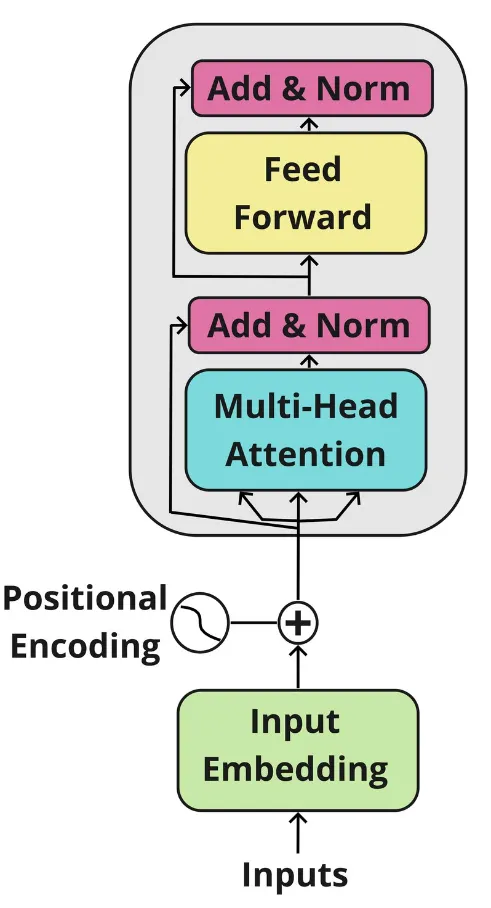

In [40]:
class EncoderBlock(nn.Module):
    
    def __init__(self, attention_block: MultiHeadAttention, feed_forward_block: FeedForward, dropout: float) -> None:
        super().__init__()

        self.attention_block = attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([Residual(dropout) for _ in range(2)])

    def forward(self, x, src_mask):
        # first residual
        x = self.residual_connections[0](x, lambda x: self.attention_block(x ,x, x, src_mask))
        # second residual
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [41]:
class Encoder(nn.Module):

    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNorm()

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

## Combine Decoder also


Similarly, the Decoder also consists of several DecoderBlocks that repeat six times in the original paper. The main difference is that it has an additional sub-layer that performs multi-head attention with a cross-attention component that uses the output of the Encoder as its keys and values while using the Decoder’s input as queries.

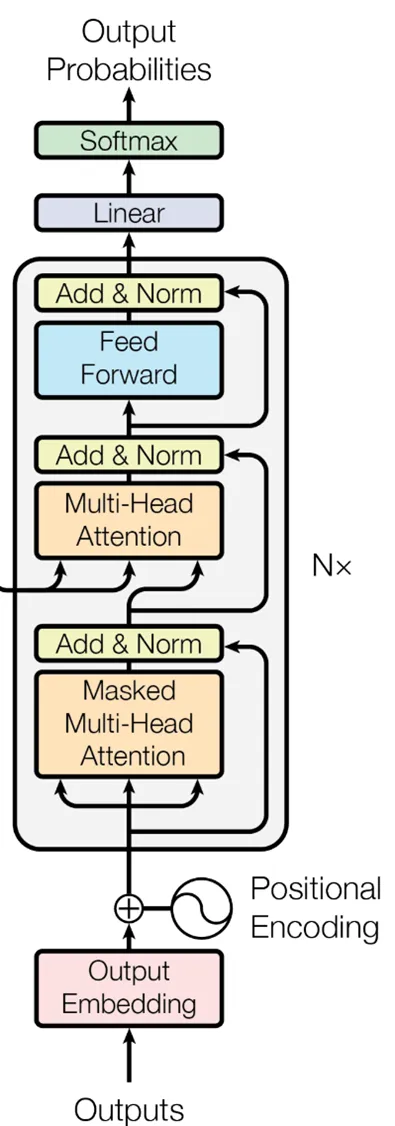

In [42]:
class DecoderBlock(nn.Module):
    def __init__(self, multi_head_attention: MultiHeadAttention, cross_attention: MultiHeadAttention, feed_forward: FeedForward, dropout: float) -> None:
        super().__init__()

        self.multi_head_attention = multi_head_attention
        self.cross_attention = cross_attention
        self.feed_forward = feed_forward
        self.residual_connections = nn.ModuleList(Residual(dropout) for _ in range(3))

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        
        # self attention block
        x = self.residual_connections[0](x, lambda x: self.multi_head_attention(x, x, x, tgt_mask))
        # cross attention block
        x = self.residual_connections[1](x, lambda x: self.cross_attention(x, encoder_output, encoder_output, src_mask))
        # feed forward
        x = self.residual_connections[2](x, self.feed_forward)

        return x

In [43]:
class Decoder(nn.Module):

    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()

        self.layers = layers
        self.norm = LayerNorm()

    def forward(self, x, encoder_output, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x)

## Final Projection Layer

You can see in the Decoder image that after running a stack of DecoderBlocks, we have a Linear Layer and a Softmax function to the output of probabilities. The ProjectionLayer class below is responsible for converting the output of the model into a probability distribution over the vocabulary, where we select each output token from a vocabulary of possible tokens.

In [44]:
class ProjectionLayer(nn.Module):

    def __init__(self, input_dim: int, voacb_size: int):
        super().__init__()
        self.projection = nn.Linear(input_dim, voacb_size)

    def forward(self, x):
        return torch.log_softmax(self.projection(x), dim=-1)

## Build the final Transformer

In [45]:
class Transformer(nn.Module):

    def __init__(self, encoder: Encoder, decoder: Decoder, src_embeddings: InputEmbeddings, trgt_embeddings: InputEmbeddings, src_positional: PositionEncoder, trgt_positional: PositionEncoder, projection_layer: ProjectionLayer) -> None:
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_embeddings = src_embeddings
        self.src_positional = src_positional
        self.trgt_embeddings = trgt_embeddings
        self.trgt_positional = trgt_positional
        self.projection_layer = projection_layer

    def encode(self, src, src_mask):
        src = self.src_embeddings(src)
        src = self.src_positional(src)
        return self.encoder(src, src_mask)
    
    def decode(self, encoder_output, src_mask, target, target_mask):
        target = self.trgt_embeddings(target)
        target = self.trgt_positional(target)
        return self.decoder(target, encoder_output, src_mask, target_mask)

    def project(self, x):
        return self.projection_layer(x)

## Build Transformer 

In [46]:
# Definin function and its parameter, including model dimension, number of encoder and decoder stacks, heads, etc.
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int = 512, N: int = 6, h: int = 8, dropout: float = 0.1, d_ff: int = 2048) -> Transformer:
    
    # Creating Embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size) # Source language (Source Vocabulary to 512-dimensional vectors)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size) # Target language (Target Vocabulary to 512-dimensional vectors)
    
    # Creating Positional Encoding layers
    src_pos = PositionEncoder(d_model, src_seq_len, dropout) # Positional encoding for the source language embeddings
    tgt_pos = PositionEncoder(d_model, tgt_seq_len, dropout) # Positional encoding for the target language embeddings
    
    # Creating EncoderBlocks
    encoder_blocks = [] # Initial list of empty EncoderBlocks
    for _ in range(N): # Iterating 'N' times to create 'N' EncoderBlocks (N = 6)
        encoder_self_attention_block = MultiHeadAttention(d_model, h, dropout) # Self-Attention
        feed_forward_block = FeedForward(d_model, d_ff, dropout) # FeedForward
        
        # Combine layers into an EncoderBlock
        encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block) # Appending EncoderBlock to the list of EncoderBlocks
        
    # Creating DecoderBlocks
    decoder_blocks = [] # Initial list of empty DecoderBlocks
    for _ in range(N): # Iterating 'N' times to create 'N' DecoderBlocks (N = 6)
        decoder_self_attention_block = MultiHeadAttention(d_model, h, dropout) # Self-Attention
        decoder_cross_attention_block = MultiHeadAttention(d_model, h, dropout) # Cross-Attention
        feed_forward_block = FeedForward(d_model, d_ff, dropout) # FeedForward
        
        # Combining layers into a DecoderBlock
        decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block) # Appending DecoderBlock to the list of DecoderBlocks
        
    # Creating the Encoder and Decoder by using the EncoderBlocks and DecoderBlocks lists
    encoder = Encoder(nn.ModuleList(encoder_blocks))
    decoder = Decoder(nn.ModuleList(decoder_blocks))
    
    # Creating projection layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size) # Map the output of Decoder to the Target Vocabulary Space
    
    # Creating the transformer by combining everything above
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)
    
    # Initialize the parameters
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
            
    return transformer

In [47]:
# Iterating through dataset to extract the original sentence and its translation 
def get_all_sentences(ds, lang):
    for pair in ds:
        yield pair['translation'][lang]

In [48]:
# Defining Tokenizer
def build_tokenizer(config, ds, lang):
    
    # Crating a file path for the tokenizer 
    tokenizer_path = Path(config['tokenizer_file'].format(lang))
    
    # Checking if Tokenizer already exists
    if not Path.exists(tokenizer_path): 
        
        # If it doesn't exist, we create a new one
        tokenizer = Tokenizer(WordLevel(unk_token = '[UNK]')) # Initializing a new world-level tokenizer
        tokenizer.pre_tokenizer = Whitespace() # We will split the text into tokens based on whitespace
        
        # Creating a trainer for the new tokenizer
        trainer = WordLevelTrainer(special_tokens = ["[UNK]", "[PAD]", 
                                                     "[SOS]", "[EOS]"], min_frequency = 2) # Defining Word Level strategy and special tokens
        
        # Training new tokenizer on sentences from the dataset and language specified 
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer = trainer)
        tokenizer.save(str(tokenizer_path)) # Saving trained tokenizer to the file path specified at the beginning of the function
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path)) # If the tokenizer already exist, we load it
    return tokenizer # Returns the loaded tokenizer or the trained tokenizer

In [49]:
def get_ds(config):
    
    # Loading the train portion of the OpusBooks dataset.
    # The Language pairs will be defined in the 'config' dictionary we will build later
    ds_raw = load_dataset('opus_books', f'{config["lang_src"]}-{config["lang_tgt"]}', split = 'train') 
    
    # Building or loading tokenizer for both the source and target languages 
    tokenizer_src = build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = build_tokenizer(config, ds_raw, config['lang_tgt'])
    
    # Splitting the dataset for training and validation 
    train_ds_size = int(0.9 * len(ds_raw)) # 90% for training
    val_ds_size = len(ds_raw) - train_ds_size # 10% for validation
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size]) # Randomly splitting the dataset
                                    
    # Processing data with the BilingualDataset class, which we will define below
    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
                                    
    # Iterating over the entire dataset and printing the maximum length found in the sentences of both the source and target languages
    max_len_src = 0
    max_len_tgt = 0
    for pair in ds_raw:
        src_ids = tokenizer_src.encode(pair['translation'][config['lang_src']]).ids
        tgt_ids = tokenizer_src.encode(pair['translation'][config['lang_tgt']]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))
        
    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')
    
    # Creating dataloaders for the training and validadion sets
    # Dataloaders are used to iterate over the dataset in batches during training and validation
    train_dataloader = DataLoader(train_ds, batch_size = config['batch_size'], shuffle = True) # Batch size will be defined in the config dictionary
    val_dataloader = DataLoader(val_ds, batch_size = 1, shuffle = True)
    
    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt # Returning the DataLoader objects and tokenizers

In [50]:
def casual_mask(size):
        # Creating a square matrix of dimensions 'size x size' filled with ones
        mask = torch.triu(torch.ones(1, size, size), diagonal = 1).type(torch.int)
        return mask == 0

In [51]:
class BilingualDataset(Dataset):
    
    # This takes in the dataset contaning sentence pairs, the tokenizers for target and source languages, and the strings of source and target languages
    # 'seq_len' defines the sequence length for both languages
    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len) -> None:
        super().__init__()
        
        self.seq_len = seq_len
        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        
        # Defining special tokens by using the target language tokenizer
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)

        
    # Total number of instances in the dataset (some pairs are larger than others)
    def __len__(self):
        return len(self.ds)
    
    # Using the index to retrive source and target texts
    def __getitem__(self, index: Any) -> Any:
        src_target_pair = self.ds[index]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]
        
        # Tokenizing source and target texts 
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids
        
        # Computing how many padding tokens need to be added to the tokenized texts 
        # Source tokens
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2 # Subtracting the two '[EOS]' and '[SOS]' special tokens
        # Target tokens
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1 # Subtracting the '[SOS]' special token
        
        # If the texts exceed the 'seq_len' allowed, it will raise an error. This means that one of the sentences in the pair is too long to be processed
        # given the current sequence length limit (this will be defined in the config dictionary below)
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError('Sentence is too long')
         
        # Building the encoder input tensor by combining several elements
        encoder_input = torch.cat(
            [
            self.sos_token, # inserting the '[SOS]' token
            torch.tensor(enc_input_tokens, dtype = torch.int64), # Inserting the tokenized source text
            self.eos_token, # Inserting the '[EOS]' token
            torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        )
        
        # Building the decoder input tensor by combining several elements
        decoder_input = torch.cat(
            [
                self.sos_token, # inserting the '[SOS]' token 
                torch.tensor(dec_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        
        )
        
        # Creating a label tensor, the expected output for training the model
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                self.eos_token, # Inserting the '[EOS]' token 
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64) # Adding padding tokens
            ]
        )
        
        # Ensuring that the length of each tensor above is equal to the defined 'seq_len'
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len
        
        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input, 
            'encoder_mask': (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(),
            'decoder_mask': (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int() & casual_mask(decoder_input.size(0)), 
            'label': label,
            'src_text': src_text,
            'tgt_text': tgt_text
        }    

In [52]:
# Define function to obtain the most probable next token
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    # Retrieving the indices from the start and end of sequences of the target tokens
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')
    
    # Computing the output of the encoder for the source sequence
    encoder_output = model.encode(source, source_mask)
    # Initializing the decoder input with the Start of Sentence token
    decoder_input = torch.empty(1,1).fill_(sos_idx).type_as(source).to(device)
    
    # Looping until the 'max_len', maximum length, is reached
    while True:
        if decoder_input.size(1) == max_len:
            break
            
        # Building a mask for the decoder input
        decoder_mask = casual_mask(decoder_input.size(1)).type_as(source_mask).to(device)
        
        # Calculating the output of the decoder
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)
        
        # Applying the projection layer to get the probabilities for the next token
        prob = model.project(out[:, -1])
        
        # Selecting token with the highest probability
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat([decoder_input, torch.empty(1,1). type_as(source).fill_(next_word.item()).to(device)], dim=1)
        
        # If the next token is an End of Sentence token, we finish the loop
        if next_word == eos_idx:
            break
            
    return decoder_input.squeeze(0) # Sequence of tokens generated by the decoder

In [53]:
# Defining function to evaluate the model on the validation dataset
# num_examples = 2, two examples per run
def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_state, writer, num_examples=2):
    model.eval() # Setting model to evaluation mode
    count = 0 # Initializing counter to keep track of how many examples have been processed
    
    console_width = 80 # Fixed witdh for printed messages
    
    # Creating evaluation loop
    with torch.no_grad(): # Ensuring that no gradients are computed during this process
        for batch in validation_ds:
            count += 1
            encoder_input = batch['encoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)
            
            # Ensuring that the batch_size of the validation set is 1
            assert encoder_input.size(0) ==  1, 'Batch size must be 1 for validation.'
            
            # Applying the 'greedy_decode' function to get the model's output for the source text of the input batch
            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)
            
            # Retrieving source and target texts from the batch
            source_text = batch['src_text'][0]
            target_text = batch['tgt_text'][0] # True translation 
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy()) # Decoded, human-readable model output
            
            # Printing results
            print_msg('-'*console_width)
            print_msg(f'SOURCE: {source_text}')
            print_msg(f'TARGET: {target_text}')
            print_msg(f'PREDICTED: {model_out_text}')
            
            # After two examples, we break the loop
            if count == num_examples:
                break

In [54]:
# We pass as parameters the config dictionary, the length of the vocabylary of the source language and the target language
def get_model(config, vocab_src_len, vocab_tgt_len):
    
    # Loading model using the 'build_transformer' function.
    # We will use the lengths of the source language and target language vocabularies, the 'seq_len', and the dimensionality of the embeddings
    model = build_transformer(vocab_src_len, vocab_tgt_len, config['seq_len'], config['seq_len'], config['d_model'])
    return model

In [55]:
# Define settings for building and training the transformer model
def get_config():
    return{
        'batch_size': 16,
        'num_epochs': 10,
        'lr': 10**-4,
        'seq_len': 350,
        'd_model': 512, # Dimensions of the embeddings in the Transformer. 512 like in the "Attention Is All You Need" paper.
        'lang_src': 'en',
        'lang_tgt': 'it',
        'model_folder': 'weights',
        'model_basename': 'tmodel_',
        'preload': None,
        'tokenizer_file': 'tokenizer_{0}.json',
        'experiment_name': 'runs/tmodel'
    }

# Function to construct the path for saving and retrieving model weights
def get_weights_file_path(config, epoch: str):
    model_folder = config['model_folder'] # Extracting model folder from the config
    model_basename = config['model_basename'] # Extracting the base name for model files
    model_filename = f"{model_basename}{epoch}.pt" # Building filename
    return str(Path('.')/ model_folder/ model_filename) # Combining current directory, the model folder, and the model filename

In [56]:
def train_model(config):
    # Setting up device to run on GPU to train faster
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device {device}")
    
    # Creating model directory to store weights
    Path(config['model_folder']).mkdir(parents=True, exist_ok=True)
    
    # Retrieving dataloaders and tokenizers for source and target languages using the 'get_ds' function
    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)
    
    # Initializing model on the GPU using the 'get_model' function
    model = get_model(config,tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)
    
    # Tensorboard
    writer = SummaryWriter(config['experiment_name'])
    
    # Setting up the Adam optimizer with the specified learning rate from the '
    # config' dictionary plus an epsilon value
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps = 1e-9)
    
    # Initializing epoch and global step variables
    initial_epoch = 0
    global_step = 0
    
    # Checking if there is a pre-trained model to load
    # If true, loads it
    if config['preload']:
        model_filename = get_weights_file_path(config, config['preload'])
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename) # Loading model
        
        # Sets epoch to the saved in the state plus one, to resume from where it stopped
        initial_epoch = state['epoch'] + 1
        # Loading the optimizer state from the saved model
        optimizer.load_state_dict(state['optimizer_state_dict'])
        # Loading the global step state from the saved model
        global_step = state['global_step']
        
    # Initializing CrossEntropyLoss function for training
    # We ignore padding tokens when computing loss, as they are not relevant for the learning process
    # We also apply label_smoothing to prevent overfitting
    loss_fn = nn.CrossEntropyLoss(ignore_index = tokenizer_src.token_to_id('[PAD]'), label_smoothing = 0.1).to(device)
    
    # Initializing training loop 
    
    # Iterating over each epoch from the 'initial_epoch' variable up to
    # the number of epochs informed in the config
    for epoch in range(initial_epoch, config['num_epochs']):
        
        # Initializing an iterator over the training dataloader
        # We also use tqdm to display a progress bar
        batch_iterator = tqdm(train_dataloader, desc = f'Processing epoch {epoch:02d}')
        
        # For each batch...
        for batch in batch_iterator:
            model.train() # Train the model
            
            # Loading input data and masks onto the GPU
            encoder_input = batch['encoder_input'].to(device)
            decoder_input = batch['decoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)
            decoder_mask = batch['decoder_mask'].to(device)
            
            # Running tensors through the Transformer
            encoder_output = model.encode(encoder_input, encoder_mask)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
            proj_output = model.project(decoder_output)
            
            # Loading the target labels onto the GPU
            label = batch['label'].to(device)
            
            # Computing loss between model's output and true labels
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))
            
            # Updating progress bar
            batch_iterator.set_postfix({f"loss": f"{loss.item():6.3f}"})
            
            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()
            
            # Performing backpropagation
            loss.backward()
            
            # Updating parameters based on the gradients
            optimizer.step()
            
            # Clearing the gradients to prepare for the next batch
            optimizer.zero_grad()
            
            global_step += 1 # Updating global step count
            
        # We run the 'run_validation' function at the end of each epoch
        # to evaluate model performance
        run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer)
         
        # Saving model
        model_filename = get_weights_file_path(config, f'{epoch:02d}')
        # Writting current model state to the 'model_filename'
        torch.save({
            'epoch': epoch, # Current epoch
            'model_state_dict': model.state_dict(),# Current model state
            'optimizer_state_dict': optimizer.state_dict(), # Current optimizer state
            'global_step': global_step # Current global step 
        }, model_filename)

# Train Model

In [57]:
warnings.filterwarnings('ignore') # Filtering warnings
config = get_config() # Retrieving config settings

In [58]:
config

{'batch_size': 16,
 'num_epochs': 10,
 'lr': 0.0001,
 'seq_len': 350,
 'd_model': 512,
 'lang_src': 'en',
 'lang_tgt': 'it',
 'model_folder': 'weights',
 'model_basename': 'tmodel_',
 'preload': None,
 'tokenizer_file': 'tokenizer_{0}.json',
 'experiment_name': 'runs/tmodel'}

In [59]:
train_model(config) # Training model with the config arguments

Using device cuda
Max length of source sentence: 309
Max length of target sentence: 274


Processing epoch 00:   7%|▋         | 120/1819 [01:15<16:18,  1.74it/s, loss=7.112] 